In [21]:
import xarray as xr
import torch
import matplotlib.pyplot as plt
import numpy as np
import pathlib

In [2]:
file_path = "../main_scripts/preproc_ifs_radklim_2020-01.nc"

In [3]:
dt = xr.open_dataset(file_path)

In [17]:
# dt

In [5]:
vars_in = ["cape_in","tclw_in","sp_in","tcwv_in","lsp_in","cp_in","tisr_in","yw_hourly_in"]

In [15]:
# dt[vars_in]

In [16]:
# #select the region that can be devided.
# dt[vars_in].isel(lon=slice(2,114), lat=slice(1,93))

In [18]:
# dt[vars_in].isel(lon=slice(2,114)).sel(lat=slice(47.5,60)).values

In [9]:
dt[vars_in].dims["lat"]

94

In [19]:
# times = dt["time"]
# times.values

In [11]:
dt[vars_in].dims["lat"]

94

In [12]:
dt["yw_hourly_tar"].isel(lon_tar=slice(16,113*10+6)).sel(lat_tar=slice(47.41,60)).dims

('time', 'lat_tar', 'lon_tar')

In [13]:
# dt["lon"].values[2:114]

In [14]:
#dt["lon_tar"].values[(2-1)*10+6:113*10+6]

Total files [PosixPath('../main_scripts/preproc_ifs_radklim_2020-01.nc'), PosixPath('../main_scripts/preproc_ifs_radklim_2020-02.nc')]
Loading file: ../main_scripts/preproc_ifs_radklim_2020-01.nc
The input variables are initialized
Original input shape: torch.Size([8, 744, 84, 112])
Original output shape: torch.Size([744, 840, 1120])
vars_in_patches after reshape: torch.Size([148800, 8, 16, 16])
vars_output_patch torch.Size([744, 10, 20, 160, 160])
vars_output_patch after reshape torch.Size([148800, 160, 160])


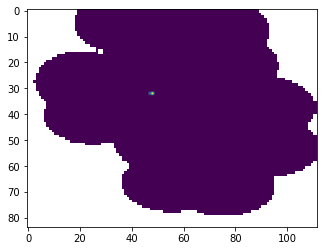

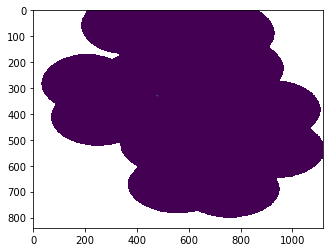

There are No. 72690 patches out of 148800 without Nan Values 
len of vars output 72690
len of vars input 72690
len of vars times 744
Loading file: ../main_scripts/preproc_ifs_radklim_2020-02.nc
The input variables are initialized
Original input shape: torch.Size([8, 744, 84, 112])
Original output shape: torch.Size([744, 840, 1120])
vars_in_patches after reshape: torch.Size([148800, 8, 16, 16])
vars_output_patch torch.Size([744, 10, 20, 160, 160])
vars_output_patch after reshape torch.Size([148800, 160, 160])


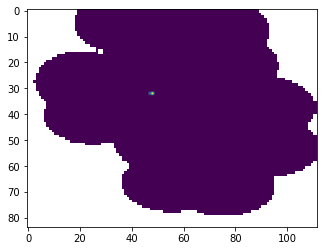

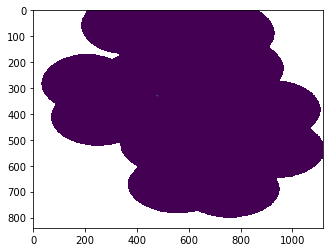

There are No. 72690 patches out of 148800 without Nan Values 


In [ ]:
class PrecipDatasetInter(torch.utils.data.IterableDataset):
    """
    This is the class used for generate dataset generator for precipitation downscaling
    """
    def __init__(self, file_path: str = None, batch_size :int = 4, patch_size: int = 16 ,
                vars_in: list = ["cape_in","tclw_in","sp_in","tcwv_in","lsp_in","cp_in","tisr_in","yw_hourly_in"],
                var_out: list = ["yw_hourly_tar"], sf: int = 10):
        """
        patch_size: the patch size for low-resolution image, 
                    the corresponding high-resolution patch size should be muliply by scale factor (sf)
        """
        
        super(PrecipDatasetInter).__init__()
        
        self.patch_size = patch_size
        self.sf = sf #scaling factor
        self.vars_in = vars_in
        self.var_out = var_out
        self.stride = self.patch_size
        

        # Search for files
        p = pathlib.Path( file_path)
        assert(p.is_dir())
        self.files = sorted(p.glob('*.nc'))
        if len(self.files) < 1:
            raise RuntimeError('No files found.')
        print("Total files",self.files)
            
        is_first = True 
        vars_in_patches_list = []
        vars_out_patches_list = []
        
        for file in self.files:
            vars_in_patches, vars_out_pathes = self.process_netcdf(file)
            vars_in_patches_list.append(vars_in_patches)
        
        vars_in_patches_list = torch.utils.data.ConcatDataset(vars_in_patches_list)
        print("Len of vars in", vars_in_patches_list.shape)
        
    
        
          

    
    def process_netcdf(self, file: int = None):
        """
        process one netcdf file: filter the Nan Values, split to patches 
        """
        print("Loading file:", file)
        dt = xr.open_dataset(file)
        
        #get input variables, and select the regions
        inputs = dt[self.vars_in].isel(lon=slice(2,114)).sel(lat=slice(47.5,60))
        output = dt[self.var_out].isel(lon_tar=slice(16,113*10+6)).sel(lat_tar=slice(47.41,60))
        
        n_lat = inputs["lat"].values.shape[0]
        n_lon = inputs["lon"].values.shape[0]

        assert inputs.dims["time"] == output.dims["time"]
        assert inputs.dims["lat"]* self.sf == output.dims["lat_tar"]
        
        n_patches_x = int(np.floor(n_lon)/self.patch_size)
        n_patches_y = int(np.floor(n_lat)/self.patch_size)
        
        #initialize the vars in after patch
        self.vars_in_per_t = torch.zeros((inputs.dims["time"], self.patch_size, self.patch_size, 
                                         n_patches_x, n_patches_y))
        
        print("The input variables are initialized")
        
        da_in = torch.from_numpy(inputs.to_array(dim = "variables").squeeze().values)
        da_out = torch.from_numpy(output.to_array(dim = "variables").squeeze().values)
        times = inputs["time"].values #get the timestamps
        print("Original input shape:", da_in.shape)
        print("Original output shape:", da_out.shape)
        
        #split into small patches, the return dim are [vars, samples,n_patch_x, n_patch_y, patch_size]
        vars_in_patches = da_in.unfold(2, self.patch_size, n_patches_x).unfold(3, self.patch_size,n_patches_y)
        vars_in_patches_shape = list(vars_in_patches.shape) 
        vars_in_patches = torch.reshape(vars_in_patches, [vars_in_patches_shape[0],
                                        vars_in_patches_shape[1]*vars_in_patches_shape[2]*vars_in_patches_shape[3], 
                                        vars_in_patches_shape[4],vars_in_patches_shape[5]])
        vars_in_patches = torch.transpose(vars_in_patches,0,1)
        print("vars_in_patches after reshape:",vars_in_patches.shape)
        
        
    
        vars_out_patches = da_out.unfold(1, self.patch_size*self.sf, 
                                            n_patches_x*self.sf).unfold(2, 
                                                                        self.patch_size*self.sf,
                                                                        n_patches_y*self.sf)
        print("vars_output_patch",vars_out_patches.shape)
        vars_out_patches_shape = list(vars_out_patches.shape)
        vars_out_patches = torch.reshape(vars_out_patches,
                                         [vars_out_patches_shape[0]*vars_out_patches_shape[1]*vars_out_patches_shape[2],
                                         vars_out_patches_shape[3],vars_out_patches_shape[4]])
        
        print("vars_output_patch after reshape",vars_out_patches.shape)
            
#         plt.imshow(da_in[-1,0,:,:])
#         plt.show()
        
#         plt.imshow(da_out[0])
#         plt.show()
      
        no_nan_idx = []
        
        #get the indx if there any nan in the sample
        [no_nan_idx.append(i) for i in range(vars_out_patches.shape[0]) if not torch.isnan(vars_out_patches[i]).any()]
        
        print("There are No. {} patches out of {} without Nan Values ".format(len(no_nan_idx), len(vars_out_patches)))
        
        #change the index from List to LongTensor type 
        no_nan_idx = torch.LongTensor(no_nan_idx)
 
        #Only get the patch that without NaN values   
        vars_out_pathes_no_nan = torch.index_select(vars_out_patches, 0, no_nan_idx)         
        vars_in_patches_no_nan = torch.index_select(vars_in_patches, 0, no_nan_idx)
        assert len(vars_out_pathes_no_nan) == len(vars_in_patches_no_nan)
        
        print("len of vars output", len(vars_out_pathes_no_nan))
        print("len of vars input", len(vars_in_patches_no_nan))
        print("len of vars times", len(times))
        
        return vars_in_patches_no_nan, vars_out_pathes_no_nan
     
        
        
    def __iter__(self):
        iter_start, iter_end = 0, 771 #todo
        
        for bidx in range(iter_start, iter_end):
            
            x = torch.zeros(self.batch_size, self.num_tokens, self.num_tokens_y, 
                           self.tok_size, self.tok_size, self.nvars)
    
        
           
def run():
    data_loader = PrecipDatasetInter(file_path = "../main_scripts")
    

run()


In [ ]:
file_path = "../main_scripts/preproc_ifs_radklim_2020-01.nc"
dt = xr.open_dataset(file_path)


In [ ]:

fig, ax = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
        sub_img = patches[:, i, j]
        ax[i][j].imshow(to_pil_image(sub_img))
        ax[i][j].axis('off')

In [ ]:
multiformer_np_rng_seed = None
# multiformer_np_rng_seed = 8392389
multiformer_np_rng = np.random.default_rng( multiformer_np_rng_seed)
multiformer_np_rng.permutation(20)
